# Mid-Distance Performance Analysis

This is an analysis of the relationships between middle-distance events. I'm mostly interested in the 800, but the general idea is to be able to predict a certain race's outcome based on your performance in other events. Particularly, being able to predict your 800m time based off of your 400m and/or 1500m/mile time.

In [25]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## TFRRS Data

The links in the following dictionary have been obtained by going to the TFRRS database archives, finding the men's 800m for the desired season/year, inspecting the table, and finding the src argument of the turbo-frame tag with id = 'list_data'. There are some patterns in the URLs, but the only consistent ones are the ones I've already automated. There are still random differences at times between divisions and between indoor and outdoor seasons.

[Example](https://tf.tfrrs.org/lists/3901/2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL):

> `<turbo-frame id="list_data" src="https://tf.tfrrs.org/list_data/3901?other_lists=`
> `https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying`
> `_FINAL&amp;limit=100&amp;event_type=53&amp;year=&amp;gender="> ... </turbo-frame>`

In [3]:
di_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3492?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3492%2F2021_2022_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3711?other_lists=https%3A%2F%2Fxc.tfrrs.org%2Flists%2F3711%2F2022_NCAA_Division_I_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3901?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4044?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4044%2F2023_NCAA_Division_I_All_Schools_Rankings&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4364?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4364%2F2023_2024_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
}

def create_dx_dict(dict: dict, division: str) -> dict:
    '''Updates the values of the DI dictionary to correspond with DII and DIII URLs. There are still some inconsistencies, so some values will have to be manually fixed after the function.
    
    Parameters:
        dict (dict): the NCAA DI Dictionary of URLs
        division (str): 'II' or 'III' to match DII or DIII
        
    Returns:
        dx_dict (dict): a dict with updated values to match the corresponding NCAA division'''
    
    dx_dict = {}
    for season in dict:
        new_url = dict[season].replace('_I_', f'_{division}_')

        table_id = dict[season].split('?')[0][-4:]
        new_table_id = str(int(table_id) + len(division))
        new_url = new_url.replace(table_id, new_table_id)
        
        dx_dict[season] = new_url

    return dx_dict


dii_dict = create_dx_dict(di_dict, 'II')     
dii_dict['outdoor_2022'] = 'https://tf.tfrrs.org/list_data/3595?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F3595%2F2022_NCAA_Division_II_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m'

diii_dict = create_dx_dict(di_dict, 'III')
diii_dict['indoor_2024'] = 'https://tf.tfrrs.org/list_data/4366?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F4366%2F2023_2024_NCAA_Div_III_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m'

naia_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3495?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3495%2F2021_2022_NAIA_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3596?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3596%2F2022_NAIA_Outdoor_Qualifying_List_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3904?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3904%2F2022_2023_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4046?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4046%2F2023_NAIA_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4368?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4368%2F2023_2024_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
}

njcaa_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3496?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3496%2F2021_2022_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3717?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3717%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3905?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F3905%2F2022_2023_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4201?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4201%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4367?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4367%2F2023_2024_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
}

### 800m and 400m

In [1]:
from scrape_tfrrs import TFRRSScraper
from glob import glob

tfrrs_400 = TFRRSScraper(400)
if not glob(f'data/tfrrs*{tfrrs_400.other_event}.csv'):
    di_tfrrs_400 = tfrrs_400.download_seasons(di_dict, division='di')
    dii_tfrrs_400 = tfrrs_400.download_seasons(dii_dict, division='dii')
    diii_tfrrs_400 = tfrrs_400.download_seasons(diii_dict, division='diii')
    naia_tfrrs_400 = tfrrs_400.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_400 = tfrrs_400.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_400.other_event}m data found in data directory')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()

[INFO] TFRRS 400m data found in data directory


<Axes: title={'center': '400m vs 800m\nn=3,285'}, xlabel='time_400', ylabel='time_800'>

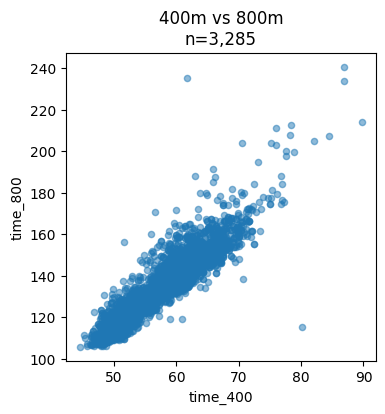

In [15]:
df_tfrrs_400.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'400m vs 800m\nn={len(df_tfrrs_400):,}'
)

### 800m and 1500m

In [6]:
tfrrs_1500 = TFRRSScraper(1500)
if not glob(f'data/tfrrs*{tfrrs_1500.other_event}.csv'):
    di_tfrrs_1500 = tfrrs_1500.download_seasons(di_dict, division='di')
    dii_tfrrs_1500 = tfrrs_1500.download_seasons(dii_dict, division='dii')
    diii_tfrrs_1500 = tfrrs_1500.download_seasons(diii_dict, division='diii')
    naia_tfrrs_1500 = tfrrs_1500.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_1500 = tfrrs_1500.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_1500.other_event}m data found in data directory')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()

[INFO] TFRRS 1500m data found in data directory


0       294.95
1       280.74
2       291.72
3       286.92
4       273.98
         ...  
1628    327.72
1629    307.64
1630    344.01
1631    336.67
1632    392.54
Name: time_1500, Length: 10030, dtype: float64

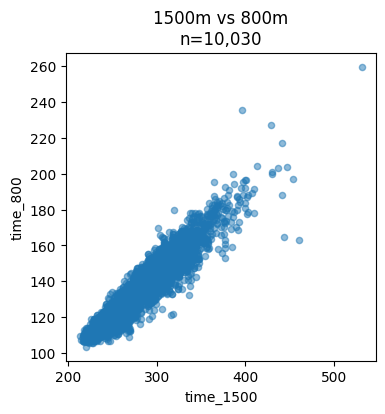

In [43]:
df_tfrrs_1500.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'1500m vs 800m\nn={len(df_tfrrs_1500):,}'
)

# df_tfrrs_1500.loc[(df_tfrrs_1500['time_800'] < 210) & 
#                   (df_tfrrs_1500['time_1500'] < 425)]

## MileSplit Data

In [11]:
if not glob('data/milesplit*.csv'):
    !python scrape_milesplit.py
else:
    print('[INFO] MileSplit data found in data directory')
    df_milesplit = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024.csv')

[INFO] MileSplit data found in data directory


<Axes: xlabel='time_400', ylabel='time_800'>

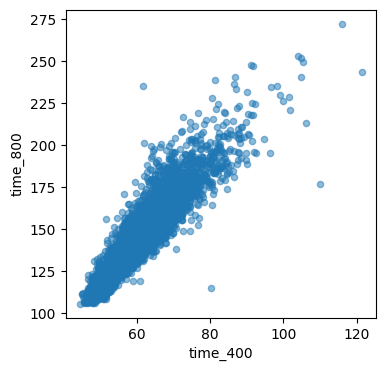

In [18]:
df_all = pd.concat([df_tfrrs_400, df_milesplit])

df_all.drop_duplicates(inplace=True) # There was a bug in the MileSplitScraper that has since been fixed, but I've not rerun the program yet

df_all.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5
)

In [21]:
lm = smf.ols(formula='time_800~time_400', data = df_all).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_800   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 5.801e+04
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:04:10   Log-Likelihood:                -29943.
No. Observations:                8746   AIC:                         5.989e+04
Df Residuals:                    8744   BIC:                         5.991e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3723      0.619     -8.676      0.000      -6.586      -4.159
time_400       2.4634      0.010    240.854      0.000       2.443       2.483
==============================================================================
Omnibus:                     2220.000   Durbin-Watson:                   1.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36003.584
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                      12.816   Cond. No.                         472.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
rlm = smf.rlm(formula='time_800~time_400', data = df_all).fit()
rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               time_800   No. Observations:                 8746
Model:                            RLM   Df Residuals:                     8744
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 14 Mar 2024                                         
Time:                        20:04:29                                         
No. Iterations:                    17                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2893      0.519    -12.127      0.000      -7.306      -5.273
time_400       2.4710      0.009    288.461      0.000       2.454       2.488
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

<Axes: xlabel='time_400', ylabel='time_800'>

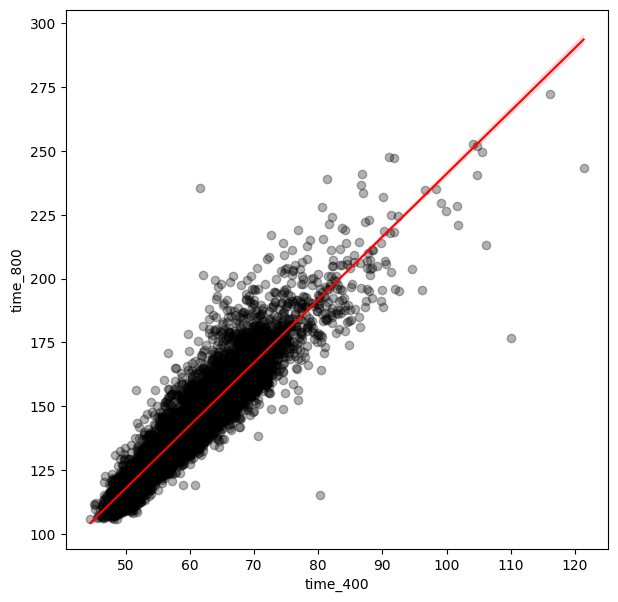

In [26]:
plt.figure(figsize = (7,7))
sns.regplot(x='time_400', y='time_800', data=df_all,
            scatter_kws={'color': 'black', 
                         'alpha': 0.3},
            line_kws={'color': 'red',
                      'lw': 1.5},
            # lowess=True,
            fit_reg=True)

# Data cleaning: remove outliers, test assumptions, 400 < 100, 800 < 250?